<a href="https://colab.research.google.com/github/ysntnss/Dog-Breed-Identification/blob/main/dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gerekli Kütüphaneleri İçe Aktarma

Bu bölümde, projede kullanılacak olan gerekli kütüphaneler içe aktarılıyor.
Pandas, NumPy, Seaborn, Matplotlib, Sklearn ve Tensorflow kütüphaneleri bu aşamada kullanılacak.

In [4]:
import pandas as pd  # Veri çerçeveleri üzerinde çalışmak için
import numpy as np  # Matematiksel işlemler için
import seaborn as sns  # Veri görselleştirmesi için
import matplotlib.pyplot as plt  # Grafik çizimleri için
from sklearn.model_selection import train_test_split  # Veri setini bölme işlemi için
from sklearn.preprocessing import LabelEncoder  # Etiketleri sayısal değerlere çevirme işlemi için
from sklearn.preprocessing import StandardScaler  # Veriyi normalize etme işlemi için
import tensorflow as tf  # Derin öğrenme modeli oluşturmak için
from tensorflow.keras.models import Sequential  # Sıralı bir model oluşturmak için
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Model katmanları için
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import classification_report, confusion_matrix
import missingno as msno
!pip install pingouin
import pingouin as pg

In [5]:
# Kaggle API anahtarını yükleme
from google.colab import files
files.upload()

# Kaggle API anahtarını doğru konuma taşıma
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Veri setini indirme
!kaggle competitions download -c dog-breed-identification

# İlgili zip dosyasını açma
!unzip dog-breed-identification.zip -d /content/


dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  dog-breed-identification.zip
replace /content/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Veri Doğrulama

In [6]:

# Veri setini okuyun
df = pd.read_csv('/content/labels.csv')

# Veri setinin genel yapısını ve ilk beş satırını inceleyelim
print("Veri seti bilgisi:")
print(df.info())

print("\nVeri setinin ilk beş satırı:")
print(df.head())

# Eksik verileri kontrol edelim
print("\nEksik veri sayısı:")
print(df.isnull().sum())

# Aykırı değerlere bakalım
print("\nAykırı Değerler:")
print(df.describe())



Veri seti bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None

Veri setinin ilk beş satırı:
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

Eksik veri sayısı:
id       0
breed    0
dtype: int64

Aykırı Değerler:
                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq       

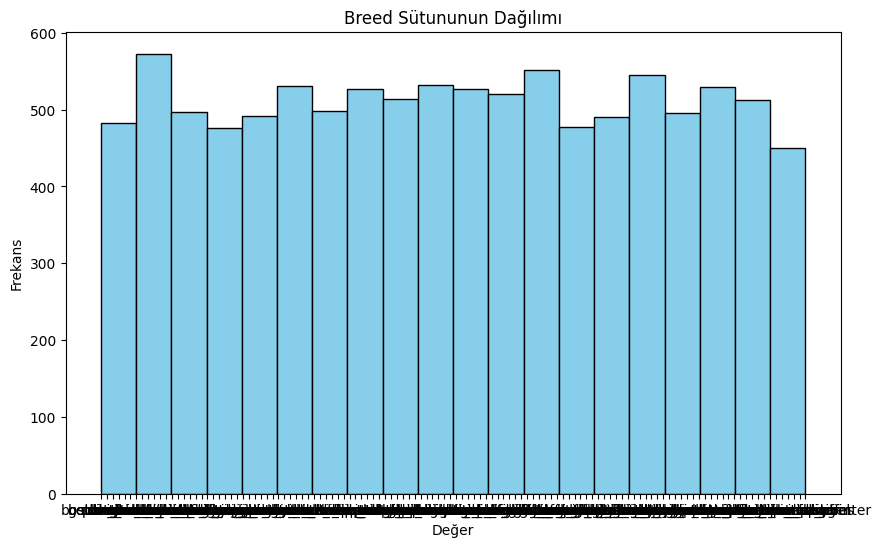

In [7]:
# Bir sütunu daha detaylı inceleme (örneğin, 'Breed')
plt.figure(figsize=(10, 6))
plt.hist(df['breed'], bins=20, color='skyblue', edgecolor='black')
plt.title('Breed Sütununun Dağılımı')
plt.xlabel('Değer')
plt.ylabel('Frekans')
plt.show()


# Veri Ön İşleme

Resimlerin piksel değerlerini ve etiketleri içeren bir veri çerçevesi oluşturma. Bu adımda veri seti üzerinde gerekli ön işlemler yapılacak.

In [8]:
# Label Encoding
label_encoder = LabelEncoder()
df['Breed_Encoded'] = label_encoder.fit_transform(df['breed'])

# Resimleri yükleyip boyutlandırma ve normalleştirme
image_size = (128, 128)
X = []
for img_id in df['id']:
    img_path = f'/content/train/{img_id}.jpg'  # Veri setinizdeki resimlerin yolunu güncelleyin
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img)
    X.append(img_array)

X = np.array(X)
X = X / 255.0  # Normalizasyon

# Veriyi eğitim ve test kümelerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, df['Breed_Encoded'], test_size=0.2, random_state=42)

# Model eğitiminde kullanılmak üzere X_train ve y_train'i ayırma
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


# Modeli oluşturma

In [9]:
# Modeli oluşturma
model = Sequential()

# Evrişimli Katmanlar
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Tam Bağlantılı Katmanlar
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Çıkış Katmanı
num_classes = len(df['breed'].unique())
model.add(Dense(num_classes, activation='softmax'))

# Modeli Derleme
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Erken durdurma tekniği
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

# Modeli Eğitme
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[es])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

### Görselleştirme

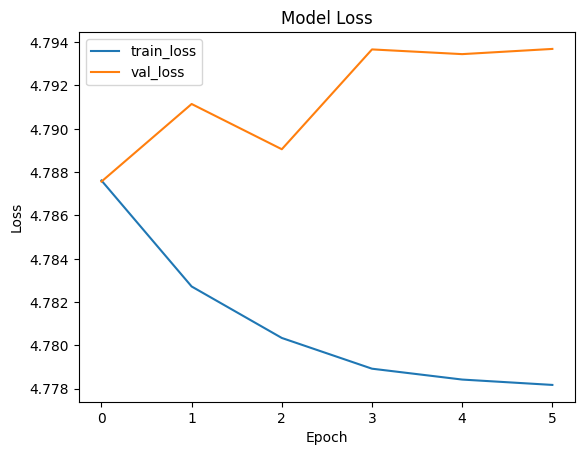

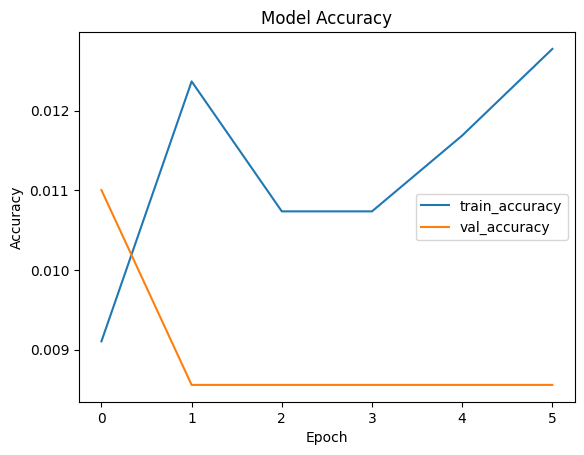

26/26 [==============================] - 0s 7ms/step


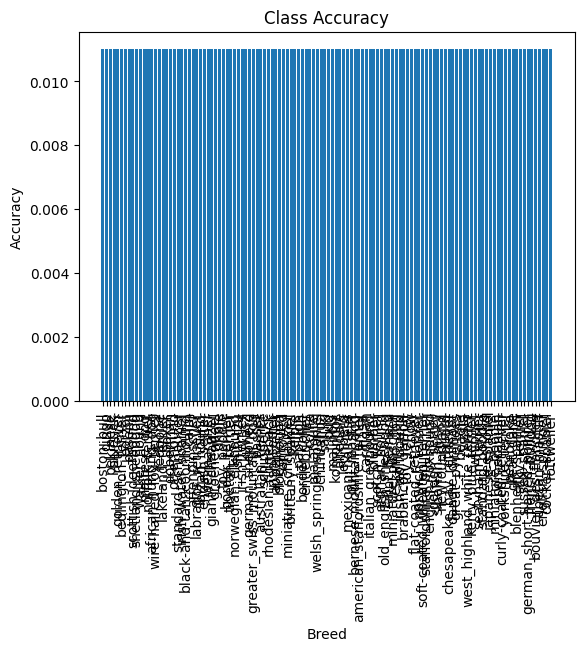

In [10]:

# Eğitim ve doğrulama kaybını çizme
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Eğitim ve doğrulama doğruluğunu çizme
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Sınıf başına doğruluk oranını çizme
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
class_acc = accuracy_score(y_val, y_pred, normalize=False) / len(y_val)
plt.bar(df['breed'].unique(), class_acc)
plt.title('Class Accuracy')
plt.xlabel('Breed')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.show()


# Hiper-parametre Optimizasyonu

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Görüntü artırma tekniği
datagen = ImageDataGenerator(
    rotation_range=20, # Derece cinsinden rastgele döndürme aralığı
    width_shift_range=0.2, # Yatay olarak rastgele kaydırma aralığı
    height_shift_range=0.2, # Dikey olarak rastgele kaydırma aralığı
    horizontal_flip=True, # Yatay olarak rastgele çevirme
    zoom_range=0.2, # Rastgele yakınlaştırma aralığı
    brightness_range=[0.8, 1.2], # Rastgele parlaklık aralığı

)


In [12]:
!pip install keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Veri setindeki benzersiz ırk sayısını bulma
num_classes = len(df['breed'].unique())

# Model oluşturma
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=16), (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(hp.Int('conv2_units', min_value=64, max_value=256, step=32), (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Keras Tuner'ı kullanarak Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Denenecek hiperparametre kombinasyonu sayısı
    directory='hyperparameter_optimization',
    project_name='dog_breed_classification'
)

# Modeli arama ile uyumlu hale getirme
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# En iyi hiperparametreleri görüntüleme
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nEn İyi Hiperparametreler:\n{best_hps}")

# Optimize edilmiş modeli oluşturma
opt_model = tuner.hypermodel.build(best_hps)
opt_model.summary()

# Optimize edilmiş modeli eğitme
opt_history = opt_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Reloading Tuner from hyperparameter_optimization/dog_breed_classification/tuner0.json

En İyi Hiperparametreler:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 96)        55392     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 96)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 86400)             0         
       